In [10]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from my_help_functions.plot import plot_loss

In [11]:
input_dir = "data/images/"
target_dir = "data/annotations/trimaps"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

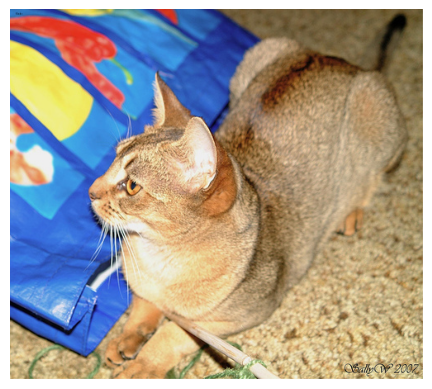

In [12]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]));

In [13]:
def display_target(target_array: np.ndarray) -> None:
    normalized_array = (target_array.astype("int8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

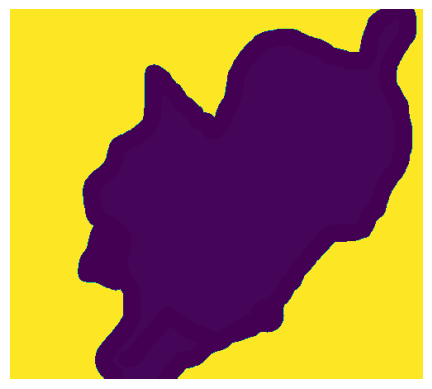

In [14]:
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

## Подготовка проверочного датасета

In [15]:
def path_to_input_image(path: str) -> np.ndarray:
    """Transform img to array

    Args:
        path (str): path to input image

    Returns:
        np.ndarray: image in array appearance
    """
    return img_to_array(load_img(path, target_size=img_size))


def path_to_target(path: str) -> np.ndarray:
    """Transform target to array

    Args:
        path (str): path to target

    Returns:
        np.ndarray: image in array appearance
    """
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

In [16]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

### Определим модель

In [18]:
def get_model(img_size: tuple, num_classes: int) -> keras.Model:
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 256)       2951

### Компиляция и обучение модели

In [15]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("models/oxford_segmentation.x", save_best_only=True)
]
history = model.fit(
    train_input_imgs,
    train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets),
)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.8631INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 49s 468ms/step - loss: 0.8631 - val_loss: 0.7423
Epoch 2/50
100/100 [==============================] - 35s 348ms/step - loss: 0.7864 - val_loss: 0.7741
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.7404INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 35s 352ms/step - loss: 0.7404 - val_loss: 0.6658
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.6752INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 35s 352ms/step - loss: 0.6752 - val_loss: 0.6060
Epoch 5/50
100/100 [==============================] - 38s 383ms/step - loss: 0.6511 - val_loss: 0.6444
Epoch 6/50
100/100 [==============================] - 43s 427ms/step - loss: 0.6158 - val_loss: 0.6936
Epoch 7/50
100/100 [==============================] - ETA: 0s - loss: 0.5937INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 45s 453ms/step - loss: 0.5937 - val_loss: 0.5354
Epoch 8/50
100/100 [==============================] - 45s 447ms/step - loss: 0.5742 - val_loss: 0.5628
Epoch 9/50
100/100 [==============================] - 44s 443ms/step - loss: 0.5568 - val_loss: 0.5775
Epoch 10/50
100/100 [==============================] - ETA: 0s - loss: 0.5359INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 43s 427ms/step - loss: 0.5359 - val_loss: 0.5003
Epoch 11/50
100/100 [==============================] - 40s 400ms/step - loss: 0.5161 - val_loss: 0.5984
Epoch 12/50
100/100 [==============================] - ETA: 0s - loss: 0.5067INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 40s 397ms/step - loss: 0.5067 - val_loss: 0.4814
Epoch 13/50
100/100 [==============================] - ETA: 0s - loss: 0.4919INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 39s 391ms/step - loss: 0.4919 - val_loss: 0.4570
Epoch 14/50
100/100 [==============================] - 38s 381ms/step - loss: 0.4714 - val_loss: 0.4573
Epoch 15/50
100/100 [==============================] - ETA: 0s - loss: 0.4612INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 39s 387ms/step - loss: 0.4612 - val_loss: 0.4209
Epoch 16/50
100/100 [==============================] - 38s 379ms/step - loss: 0.4574 - val_loss: 0.4502
Epoch 17/50
100/100 [==============================] - 38s 380ms/step - loss: 0.4358 - val_loss: 0.4293
Epoch 18/50
100/100 [==============================] - 38s 382ms/step - loss: 0.4333 - val_loss: 0.4881
Epoch 19/50
100/100 [==============================] - 38s 380ms/step - loss: 0.4162 - val_loss: 0.4386
Epoch 20/50
100/100 [==============================] - 38s 377ms/step - loss: 0.4032 - val_loss: 0.4449
Epoch 21/50
100/100 [==============================] - 38s 375ms/step - loss: 0.3907 - val_loss: 0.4630
Epoch 22/50
100/100 [==============================] - ETA: 0s - loss: 0.3889INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 38s 383ms/step - loss: 0.3889 - val_loss: 0.3873
Epoch 23/50
100/100 [==============================] - ETA: 0s - loss: 0.3711INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 38s 378ms/step - loss: 0.3711 - val_loss: 0.3794
Epoch 24/50
100/100 [==============================] - 37s 366ms/step - loss: 0.3702 - val_loss: 0.3831
Epoch 25/50
100/100 [==============================] - ETA: 0s - loss: 0.3549INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


INFO:tensorflow:Assets written to: models/oxford_segmentation.x/assets


100/100 [==============================] - 39s 385ms/step - loss: 0.3549 - val_loss: 0.3643
Epoch 26/50
100/100 [==============================] - 38s 379ms/step - loss: 0.3491 - val_loss: 0.3653
Epoch 27/50
100/100 [==============================] - 38s 379ms/step - loss: 0.3418 - val_loss: 0.3681
Epoch 28/50
100/100 [==============================] - 37s 372ms/step - loss: 0.3283 - val_loss: 0.3695
Epoch 29/50
100/100 [==============================] - 37s 365ms/step - loss: 0.3165 - val_loss: 0.3821
Epoch 30/50
100/100 [==============================] - 36s 361ms/step - loss: 0.3149 - val_loss: 0.4165
Epoch 31/50
100/100 [==============================] - 36s 361ms/step - loss: 0.3019 - val_loss: 0.3833
Epoch 32/50
100/100 [==============================] - 36s 357ms/step - loss: 0.2941 - val_loss: 0.4180
Epoch 33/50
100/100 [==============================] - 36s 356ms/step - loss: 0.2901 - val_loss: 0.4347
Epoch 34/50
100/100 [==============================] - 36s 363ms/step - loss

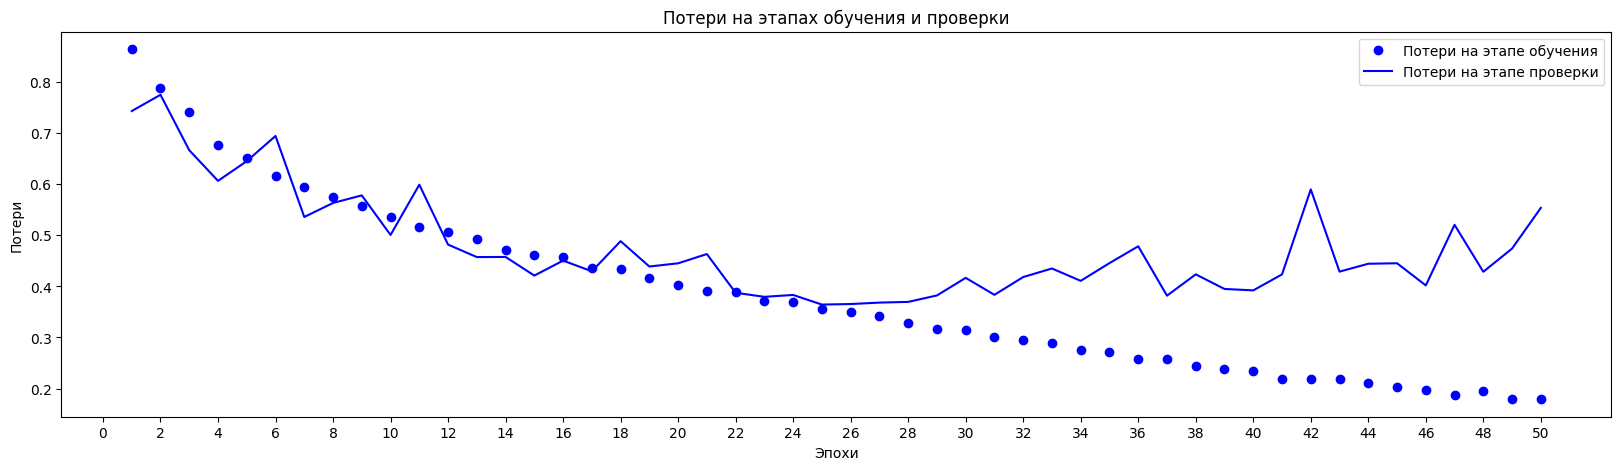

In [19]:
plt.figure(figsize=(20, 5))
plot_loss(history)

In [19]:
# Выбираем лучшую модель
model = keras.models.load_model("models/oxford_segmentation.x")

''

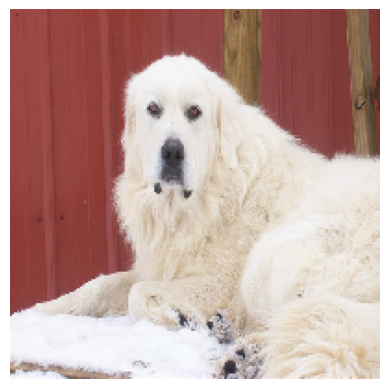

In [20]:
i = 3
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
;

1/1 [==============================] - 0s 159ms/step


2024-03-31 19:27:35.433842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


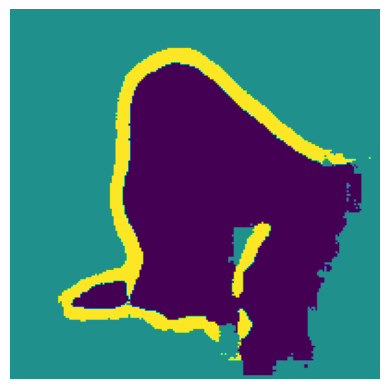

In [21]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
    ;


mask = model.predict(np.expand_dims(test_image, 0))[0]

display_mask(mask)